In [1]:
#some basic modules for plotting and numerics
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pickle
import pandas as pd
import copy
import tools as to
from numpy import vectorize

#FFT modules 
from mcfit import P2xi
from mcfit import xi2P

#Interpolation modules 
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

#Integrator 
import scipy.integrate as sci
from scipy import special

#Timer
from timeit import default_timer as timer
from datetime import timedelta
import time

#Parallelisation 
from joblib import Parallel, delayed
from joblib import Memory

location = './cachedir'
memory = Memory(location, verbose=0)
%matplotlib inline

In [2]:
outputfolder ='./data/output'
to.mkdirp(outputfolder)

axis_font = {'fontname':'Arial', 'size':'12'}
font1 = {'size'   : 16, 'family':'STIXGeneral'}
font2 = {'size'   : 20, 'family':'STIXGeneral'}
font3 = {'size'   : 24, 'family':'STIXGeneral'}
font4 = {'size'   : 24, 'family':'STIXGeneral'}

axislabelfontsize='x-large'

# Choose redshift and model parameters

In [3]:
redshift_dict = {'1.0':'z1.000','0.5':'z0.500'}

In [47]:
# Choose some parameters 
pkreal_model = 'halofit'
g_model = 'lcdm'


#Redshift, linear bias, sigma_{iso,pt} and growth rate of structure (used for Kaiser multipoles)
#Defaults are for multidark cosmology halo catalogue measurements - see arxiv 1911.04391
zred = '1.0' 
mybias = 2.77 
sigma_iso = 5.23*mybias
frate = 0.8728

# zred = '0.5' # for PT and sims 
# mybias = 2.04
# sigma_iso = 10.07*mybias
#frate = 0.7549


## Load theory power spectrum from file (e.g. HALOFIT, 1-loop, etc.) 

In [5]:
#Get theory prediction
#Data file columns are k, p_linear, p_halofit
def loadTheoryPk(z_key='1.0', model='halofit'):
    zstr = redshift_dict[z_key]
    if model=='linear':
        pk_read = np.loadtxt('./data/theory/pofk_'+zstr+'.dat')
        pk_out= pk_read[:,[0,1]]
    if model=='halofit':
        pk_read = np.loadtxt('./data/theory/pofk_'+zstr+'.dat')
        pk_out = pk_read[:,[0,2]]
    return pk_out

In [6]:
#create theory splines 

k_pt = loadTheoryPk(z_key=zred, model='halofit')[:,0]
pktabl = loadTheoryPk(z_key=zred, model='linear')[:,1]
pktab = loadTheoryPk(z_key=zred, model='halofit')[:,1]

pkl_intp_plot = interp1d(k_pt, mybias**2*pktabl, kind='linear')
pk_intp_plot = interp1d(k_pt, mybias**2*pktab, kind='linear')


## Load N-body power spectrum and correlation functions

In [7]:
def pkS_simulation(z_key='1.0'):
    zstr = redshift_dict[z_key]
    pk_simu = np.loadtxt('./data/multidark/pk/pofk_'+zstr+'.txt')
    k_simu = pk_simu[:,0]
    Pk_simu = pk_simu[:,1]
    P0_simu = pk_simu[:,2] 
    P2_simu = pk_simu[:,3] 
    P4_simu = pk_simu[:,4]
    return k_simu, Pk_simu, P0_simu, P2_simu, P4_simu

def xi_simulation(z_key='1.0'):
    zstr = redshift_dict[z_key]
    xi_simu = np.loadtxt('./data/multidark/xi/corr_'+zstr+'_better.txt')
    r_simu = xi_simu[:,0]
    xir_simu = xi_simu[:,1]
    xi0_simu = xi_simu[:,2]
    xi2_simu = xi_simu[:,3]
    xi4_simu = xi_simu[:,4]
    return r_simu, xir_simu, xi0_simu, xi2_simu, xi4_simu

def xi_simulation_lin(z_key='1.0'):
    zstr = redshift_dict[z_key]
    xirl_simu = np.loadtxt('./data/multidark/xi/linear_corrfunc_DM_'+zstr+'.txt')
    rl_simu = xirl_simu[:,0]
    xil_simu = xirl_simu[:,1]
    return rl_simu, xil_simu

# Load into arrays 
k_simu, Pk_simu, P0_simu, P2_simu, P4_simu = pkS_simulation(z_key=zred)
s_simu, xi_simu, xi0_simu, xi2_simu, xi4_simu = xi_simulation(z_key=zred)
rl_simu, xil_simu = xi_simulation_lin()


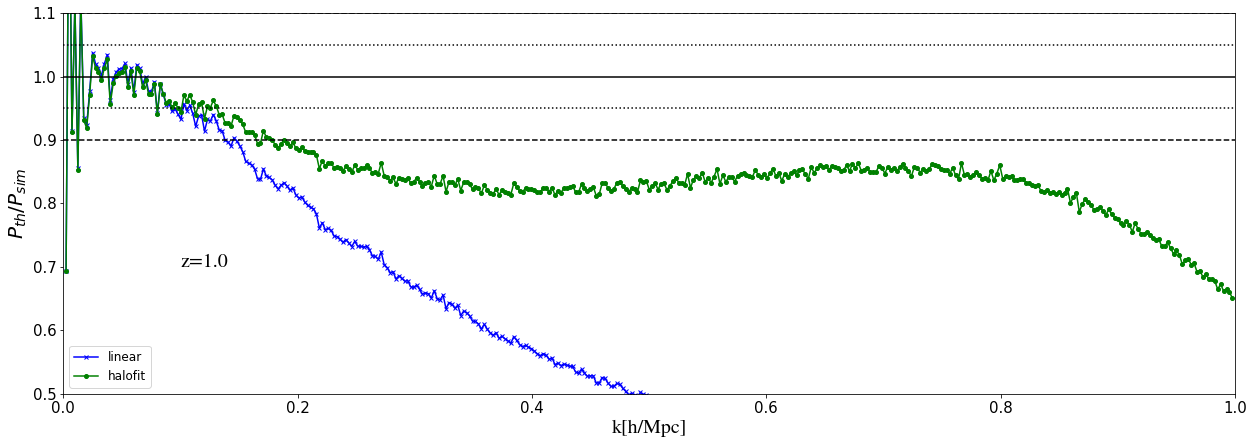

In [8]:
#Plot real space p(k) vs N-body measurements
plt.figure(figsize=(21,7))
ax = plt.subplot(1,1,1)
plt.plot(k_simu, pkl_intp_plot(k_simu)/Pk_simu , color='blue', marker='x', markersize=4, label = 'linear')
plt.plot(k_simu, pk_intp_plot(k_simu)/Pk_simu , color='green', marker='o', markersize=4, label = 'halofit')

plt.axhline(y=1., xmin=0., xmax=10,color='k')
plt.axhline(y=1.1, xmin=0., xmax=10,color='k',linestyle='dashed')
plt.axhline(y=1.05, xmin=0., xmax=10,color='k',linestyle='dotted')
plt.axhline(y=0.95, xmin=0., xmax=10,color='k',linestyle='dotted')
plt.axhline(y=0.9, xmin=0., xmax=10,color='k',linestyle='dashed')
plt.xlim(0.0001,1)
plt.ylim(0.5,1.1)

plt.text(0.1, 0.7 , "z="+zred,  **font2 )

plt.legend(loc='best',prop={'size': 12})
plt.ylabel("$P_{th}/P_{sim}$", **font2)
plt.xlabel("k[h/Mpc]", **font2)
ax.tick_params(axis='both', which='major', labelsize=15)

# From power spectrum to correlation function

In [9]:
def pkReal_logSampling(z_key='1.0', model='halofit', npoints=1024 ): #like in Nbodykit):
    pk_arr = loadTheoryPk(z_key=z_key, model=model)
    ktab = pk_arr[:,0]
    pktab = pk_arr[:,1]
    pk_intp_tmp = interp1d(ktab, pktab, kind='linear')
    #Define a vector of k modes 
    #logarithmically spaced as required by mcfit
    kvec = np.logspace(np.log10(ktab[0]),np.log10(ktab[-1]),npoints)
    pkvec = pk_intp_tmp(kvec)
    return kvec, pkvec

In [10]:
kvec, pkvecl = pkReal_logSampling(z_key=zred, model='linear') # linear vector
kvec, pkvec = pkReal_logSampling(z_key=zred, model='halofit') # halofit vector

#Theory prediction Linear
xil = P2xi(kvec,l=0,lowring=True)
rrl, CFl = xil(pkvecl, extrap=True)
corrFunc_intp_lin = interp1d(rrl,CFl, kind='cubic',fill_value='extrapolate')

#Theory prediction Linear halofit
xi = P2xi(kvec,l=0,lowring=True)
rr, CF = xi(pkvec, extrap=True)
corrFunc_intp_hf = interp1d(rr,CF, kind='cubic',fill_value='extrapolate')

#N-body interpolator 
corrFunc_int_sim = interp1d(s_simu,xi_simu, kind='cubic')

#Construct interpolated function from simulated data that transitions to halofit for r<r_low and for r>r_high - should be chosen based on comparisons
r_high=192 #z=0.5
#r_high=137 # z=1
r_low= 11
def xi_sim_full(r):
    myresult = float()
    if (r > r_low and r < r_high):
        myresult =  corrFunc_int_sim(r)
    else:
        myresult = mybias**2*corrFunc_intp_hf(r) 
    return myresult

xi_sim_fullv = vectorize(xi_sim_full)


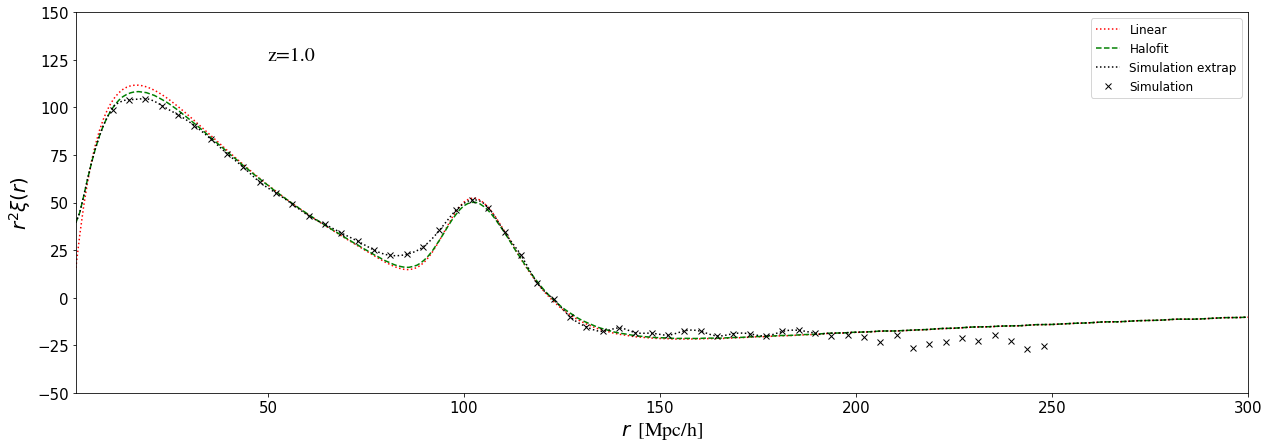

In [11]:
#Plot real space xi(r) vs N-body measurements
rvec = np.linspace(1,300,300) 

plt.figure(figsize=(21,7))
ax = plt.subplot(1,1,1)

plt.plot(rvec,  mybias**2*rvec**2*corrFunc_intp_lin(rvec), linestyle='dotted', label='Linear',color='r')
plt.plot(rvec,  mybias**2*rvec**2*corrFunc_intp_hf(rvec), linestyle='dashed', label='Halofit',color='g')
plt.plot(rvec,  rvec**2*xi_sim_fullv(rvec) ,linestyle='dotted', color='k',label='Simulation extrap')
plt.plot(s_simu,  s_simu**2*xi_simu,linestyle='none',marker='x',color='k',label='Simulation')

plt.text(50, 125 , "z="+zred,  **font2 )

plt.legend(loc='best',prop={'size': 12})
plt.ylim(-50,150)
plt.xlim(1,300)
plt.ylabel("$r^2 \\xi(r) $",**font2)
plt.xlabel("$r \,$ [Mpc/h]",**font2)
ax.tick_params(axis='both', which='major', labelsize=15)

##  Velocity statistics for Gaussian streaming model

In [12]:
#Get theory prediction for v_12
#Data file columns are k, v_linear, v_1-loop

def v12_fromTheory(z_key='1.0', linear=False):
    zstr = redshift_dict[z_key]
    v12tab = np.loadtxt("./data/theory/v12_"+zstr+".dat")
    rr = v12tab[:,0]
    if linear==True:
        ind = 1
    else:
        ind = 2
    v12_arr = v12tab[:,[0,ind]]
    return v12_arr

#Create Splines 
# Linear
v12_arr_lin = v12_fromTheory(z_key=zred, linear=True)
# 1-Loop
v12_arr_loop = v12_fromTheory(z_key=zred, linear=False)

v12_intp_lin = interp1d(v12_arr_lin[:,0], v12_arr_lin[:,1], kind='cubic')
v12_intp_loop = interp1d(v12_arr_loop[:,0], v12_arr_loop[:,1], kind='cubic')

In [13]:
# s_12^2 = (1-mu^2)s_{12,par}^2 + mu^2 s_{12,perp}^2 = mu^2(s_{12,perp}^2 - s_{12,par}^2) + s_{12,par}^2 = mu^2 sa + sb

# Get theory prediction for s12a: mu dependent component  
def s12a_fromTheory(z_key='1.0', linear=False):
    zstr = redshift_dict[z_key]
    s12tab = np.loadtxt("./data/theory/s12_"+zstr+".dat")
    if linear==True:
        ind = 1
    else:
        ind = 3
    s12_arr = s12tab[:,[0,ind]]
    return s12_arr

# Get theory prediction for s12b: mu-independent component
def s12b_fromTheory(z_key='1.0', linear=False):
    zstr = redshift_dict[z_key]
    s12tab = np.loadtxt("./data/theory/s12_"+zstr+".dat")
    if linear==True:
        ind = 2
    else:
        ind = 4
    s12_arr = s12tab[:,[0,ind]]
    return s12_arr


#Create splines for mu^2 dep and indep pieces from linear theory
s12a_arr = s12a_fromTheory(z_key=zred, linear=True)
s12a_intp = interp1d(s12a_arr[:,0],s12a_arr[:,1], kind='cubic')
s12b_arr = s12b_fromTheory(z_key=zred, linear=True)
s12b_intp = interp1d(s12b_arr[:,0],s12b_arr[:,1], kind='cubic')

#Create splines for mu^2 piece and only r dependent piece from 1-loop theory
s12a2_arr = s12a_fromTheory(z_key=zred, linear=False)
s12a2_intp = interp1d(s12a2_arr[:,0],s12a2_arr[:,1], kind='cubic')
s12b2_arr = s12b_fromTheory(z_key=zred, linear=False)
s12b2_intp = interp1d(s12b2_arr[:,0],s12b2_arr[:,1], kind='cubic')


#Theory 2d velocity dispersion - linear
def s12_2d_lin(r, mu):
    myresult = np.sqrt(s12a_intp(r)*mu**2 + s12b_intp(r))
    return myresult

#Theory 2d velocity dispersion - 1-loop with free sigma_iso parameter 
def s12_2d_loop(r, mu, iso):
    myresult = np.sqrt((s12a2_intp(r))*mu**2 + s12b2_intp(r) + iso)
    return myresult


In [15]:
## There is small offset which we need to account for (can be absorbed in sigma_iso)
offsetscale = 198
myoffsetloop = s12_2d_loop(offsetscale, 0, 0)**2  -  s12_2d_lin(offsetscale, 0)**2

print(myoffsetloop)

0.09313254653660508


## Get N-body measurements for velocity statistics 

In [16]:
# Get N-body measurement for v_12

# Here the s12_perp and s12_par components are given as s_12^2 = (1-mu^2)s_{12,par}^2 + mu^2 s_{12,perp}^2 
def vs12_simulation(z_key='1.0'):
    zstr = redshift_dict[z_key]
    vel_simu = np.loadtxt('./data/multidark/vel_stat/v12_s12_'+zstr+'.dat')
    
    # Note that a unit conversion factor of (a H/H0)^{-1} needs to be applied to (these) simulation measurements 
    if(z_key=='0.'):
        mynorm = 100
    elif(z_key=='0.5'):
        mynorm = 87.66
    elif(z_key=='1.0'): 
        mynorm = 88.75    
        
    r_simu = vel_simu[:,0]
    mu_simu = vel_simu[:,1]
    v12_simu = vel_simu[:,2]/mynorm
    v12_perp_simu = vel_simu[:,3] /mynorm
    v12_par_simu = vel_simu[:,4] /mynorm
    s_12_simu = vel_simu[:,5]/mynorm
    s_12_perp_simu = vel_simu[:,6]/mynorm
    s_12_par_simu = vel_simu[:,7]/mynorm
    
    return r_simu, mu_simu, v12_simu, v12_perp_simu, v12_par_simu,  s_12_simu, s_12_perp_simu, s_12_par_simu

# Create arrays 
rvel, muvel, v12sim, v12perpsim, v12parsim, s12sim, s12perpsim, s12parsim =  vs12_simulation(z_key=zred)

# Average over the mu bins for the mu-independent quantities : v12, s12par, s12perp
mytabv = []
mytabspar = []
mytabsperp = []

for i in range(50):
    ind1 = i*10
    ind2 = (i+1)*10
    mytabv.append([rvel[ind1],np.average(v12sim[ind1:ind2])])     
    mytabspar.append([rvel[ind1],np.average(s12parsim[ind1:ind2])])     
    mytabsperp.append([rvel[ind1],np.average(s12perpsim[ind1:ind2])])     

mytabv = np.array(mytabv)
mytabspar = np.array(mytabspar)
mytabsperp = np.array(mytabsperp)

#spline the quantities 
v12s_intp = interp1d(mytabv[:,0], mytabv[:,1], kind='cubic',fill_value='extrapolate')
s12spar_intp = interp1d(mytabspar[:,0], mytabspar[:,1] , kind='cubic',fill_value='extrapolate') #par
s12sperp_intp = interp1d(mytabsperp[:,0], mytabsperp[:,1] , kind='cubic',fill_value='extrapolate') #perp


# give N-body v_12 and s12 a transition into linear theory at large scales 
#set callibration scales - chosen to  give smooth transitioon with theory predictions 
rv_scale  = 125
rs_scale = 198

# v12(r)
def v12s_ext(r):
    myresult = float()
    if (r > rv_scale):
        myresult = v12_intp_lin(r)
    else:
        myresult =  v12s_intp(r)
        
    return myresult

v12s_v = vectorize(v12s_ext)

#force the parallel component to match linear theory at large separations for smooth transition
myoffset = s12spar_intp(offsetscale)**2 - s12b_intp(offsetscale)


# s12 parallel 
def s12par_ext(r):
    myresult = float()
    if (r > rs_scale):
        myresult = np.sqrt(s12b_intp(r) + myoffset)
    else:
        myresult =  s12spar_intp(r) 
    return myresult


# s12 perpendicular 
def s12perp_ext(r):
    myresult = float()
    if (r > rs_scale):
        myresult = np.sqrt(s12a_intp(r) + s12b_intp(r) + myoffset)  #-0.03 #0.03 ensures smootth transition for z=1
    else:
        myresult =  s12sperp_intp(r) 
    return myresult


s12par_extv = vectorize(s12par_ext)
s12perp_extv = vectorize(s12perp_ext)


#Simulation 2d velocity dispersion function of r, mu and some offset factor callibration 
def s12_2d_sim(r, mu,offsw):
    myresult = np.sqrt((s12perp_extv(r)**2 - s12par_extv(r)**2) *mu**2 + s12par_extv(r)**2 - myoffset*offsw) 
    return myresult

print(myoffset)

6.575264476104152


/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


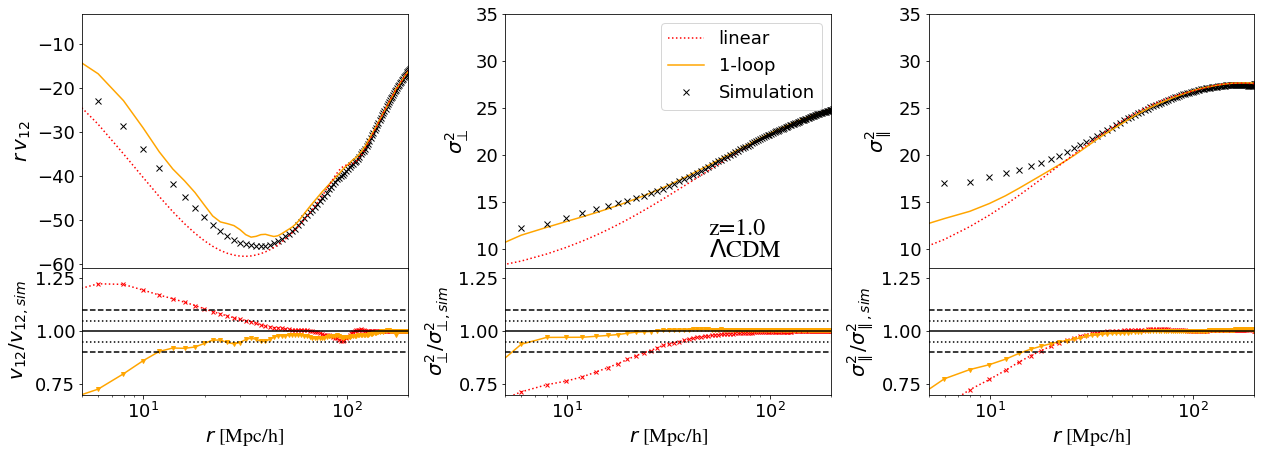

In [17]:
#Plot all statistics 

xv = np.linspace(2,299,150)
yloop = v12_intp_loop(xv)
ylin =  v12_intp_lin(xv)
ysim = v12s_v(xv)

plt.figure(figsize=(21,7))
ax = plt.subplot(3,3,(1,4))
ax.set_xscale("log")

plt.plot(xv,  xv*ysim ,label='Simulation',linestyle='none',marker='x',color='k')
plt.plot(xv, xv*yloop  ,label='1-loop', linestyle='solid', color='orange')
plt.plot(xv, xv*ylin  ,label='linear', linestyle='dotted', color='red')
plt.ylabel("$r \, v_{12}$",**font2)
#plt.ylim(-2,0)
plt.xlim(5,200)
ax.tick_params(axis='both', which='major', labelsize=18)

ax = plt.subplot(3,3,7)
ax.set_xscale("log")

plt.plot(xv, ylin/ysim  ,label='linear', linestyle='dotted', color='red', marker='x', markersize=4)
plt.plot(xv, yloop/ysim  ,label='1-loop', linestyle='solid', color='orange', marker='v', markersize=4)

plt.axhline(y=1., xmin=0., xmax=10,color='k')
plt.axhline(y=1.1, xmin=0., xmax=10,color='k',linestyle='dashed')
plt.axhline(y=1.05, xmin=0., xmax=10,color='k',linestyle='dotted')
plt.axhline(y=0.95, xmin=0., xmax=10,color='k',linestyle='dotted')
plt.axhline(y=0.9, xmin=0., xmax=10,color='k',linestyle='dashed')
ax.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel("$\, v_{12}/v_{12,sim}$",**font2)
plt.xlabel("$r$ [Mpc/h]", **font2)
plt.ylim(0.7,1.3)
plt.xlim(5,200)


myoffsetloopx = myoffsetloop - sigma_iso

ax = plt.subplot(3,3,(2,5))
ax.set_xscale("log")
muval = 0
sigmaiso = 0
sigmaiso2 = 0.
yv = s12_2d_lin(xv,muval)**2 + myoffset
ys = s12_2d_sim(xv,muval,0)**2 
yloop = s12_2d_loop(xv,muval,0)**2  + myoffset

plt.plot(xv,yv, linestyle='dotted',color='red' ,label='linear')
plt.plot(xv,yloop, label='1-loop', linestyle='solid', color='orange')
plt.plot(xv,ys , label='Simulation',linestyle='none',marker='x',color='k')
plt.ylim(8,35)
plt.xlim(5,200)
plt.legend(loc='best',prop={'size': 18})
plt.text(50, 11.5 , 'z='+zred,  **font3 )
plt.text(50, 9.2 , '$\Lambda$CDM',  **font3 )

plt.ylabel("$\sigma^2_{\\bot}$",**font2)
ax.tick_params(axis='both', which='major', labelsize=18)


ax = plt.subplot(3,3,8)
ax.set_xscale("log")

plt.plot(xv, yv/ys  ,label='linear', linestyle='dotted', color='red', marker='x', markersize=4)
plt.plot(xv, yloop/ys  ,label='1-loop', linestyle='solid', color='orange', marker='v', markersize=4)
plt.axhline(y=1., xmin=0., xmax=10,color='k')
plt.axhline(y=1.1, xmin=0., xmax=10,color='k',linestyle='dashed')
plt.axhline(y=1.05, xmin=0., xmax=10,color='k',linestyle='dotted')
plt.axhline(y=0.95, xmin=0., xmax=10,color='k',linestyle='dotted')
plt.axhline(y=0.9, xmin=0., xmax=10,color='k',linestyle='dashed')
ax.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel("$\sigma^2_{\\bot}/\sigma^2_{\\bot,sim}$",**font2)
plt.xlabel("$r$ [Mpc/h]", **font2)
plt.ylim(0.7,1.3)
plt.xlim(5,200)


ax = plt.subplot(3,3,(3,6))
ax.set_xscale("log")
muval = 1
sigmaiso = 0
sigmaiso2 = 0.
yv = s12_2d_lin(xv,muval)**2  + myoffset 
ys = s12_2d_sim(xv,muval,0)**2 -  v12s_v(xv)**2
yloop = s12_2d_loop(xv,muval,0)**2  -  v12_intp_lin(xv)**2 + myoffset

plt.plot(xv,ys , label='Simulation',linestyle='none',marker='x',color='k')
plt.plot(xv,yloop, label='1-loop', linestyle='solid', color='orange')
plt.plot(xv,yv, linestyle='dotted',color='red' ,label='linear')
plt.ylim(8,35)
plt.xlim(5,200)
plt.ylabel("$\sigma^2_{\\parallel}$",**font2)
plt.xlabel("$r$ [Mpc/h]", **font2)
ax.tick_params(axis='both', which='major', labelsize=18)

ax = plt.subplot(3,3,9)
ax.set_xscale("log")
plt.plot(xv, yv/ys  ,label='linear', linestyle='dotted', color='red', marker='x', markersize=4)
plt.plot(xv, yloop/ys  ,label='1-loop', linestyle='solid', color='orange', marker='v', markersize=4)
plt.axhline(y=1., xmin=0., xmax=10,color='k')
plt.axhline(y=1.1, xmin=0., xmax=10,color='k',linestyle='dashed')
plt.axhline(y=1.05, xmin=0., xmax=10,color='k',linestyle='dotted')
plt.axhline(y=0.95, xmin=0., xmax=10,color='k',linestyle='dotted')
plt.axhline(y=0.9, xmin=0., xmax=10,color='k',linestyle='dashed')
ax.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel("$\sigma^2_{\\parallel}/\sigma^2_{\\parallel,sim}$",**font2)
plt.xlabel("$r$ [Mpc/h]", **font2)

plt.ylim(0.7,1.3)
plt.xlim(5,200)

plt.setp(plt.subplot(3,3,(1,4)).get_xticklabels(), visible=False)
plt.setp(plt.subplot(3,3,(2,5)).get_xticklabels(), visible=False)
plt.setp(plt.subplot(3,3,(3,6)).get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=0.0)
plt.subplots_adjust(wspace=0.30)


## Compare Gaussian PDFs to N-body measurement

In [24]:
## The multidark simulation-measured PDF 
import scipy.interpolate

def pdf_fromSimu(z_key='1.0'):
    zstr = redshift_dict[z_key]
    probtab = np.loadtxt("./data/multidark/vel_stat/pdf_r_mu_"+zstr+".txt")
    if(z_key=='0.'):
        mynorm = 100
    elif(z_key=='0.5'):
        mynorm = 87.66
    elif(z_key=='1.0'): 
        mynorm = 88.75        
    r_simu = probtab[:,0]
    mu_simu = probtab[:,1]
    v12_simu = probtab[:,2]/mynorm
    prob_simu = probtab[:,3]*mynorm
    return r_simu, mu_simu, v12_simu, prob_simu

r_simu, mu_simu, v12p_simu, prob_simu =pdf_fromSimu(z_key=zred)

cartcoord = list(zip(r_simu,mu_simu,v12p_simu))


In [25]:
# 2D interpolation of PDF
mypdf = scipy.interpolate.LinearNDInterpolator(cartcoord,prob_simu)

# Gaussian PDF from theory and simulations


In [27]:
def pdf_theory_lin(r, mu, v):
    
    v12 = v12_intp_lin(r)  # linear 
    s12_sq = s12_2d_lin(r, mu)**2  #linear

    pdist = np.exp(-(v - mu*v12)**2 / (2 * s12_sq ) ) /np.sqrt(2*np.pi *s12_sq)
   
    return pdist


def pdf_theory_loop(r, mu, v, off):

    v12 = v12_intp_loop(r) 
    s12_sq = s12_2d_loop(r, mu, off)**2 - (v12*mu)**2
    
    pdist = np.exp(-(v - mu*v12)**2 / (2 * s12_sq ) ) /np.sqrt(2*np.pi *s12_sq)
   
    return pdist

def pdf_gsm_sim(r, mu, v, off):

    v12 = v12s_v(r) #  
    s12_sq = s12_2d_sim(r, mu,0)**2 - (v12*mu)**2 + off
    
    pdist = np.exp(-(v - mu*v12)**2 / (2 * s12_sq ) ) /np.sqrt(2*np.pi *s12_sq)
   
    return pdist


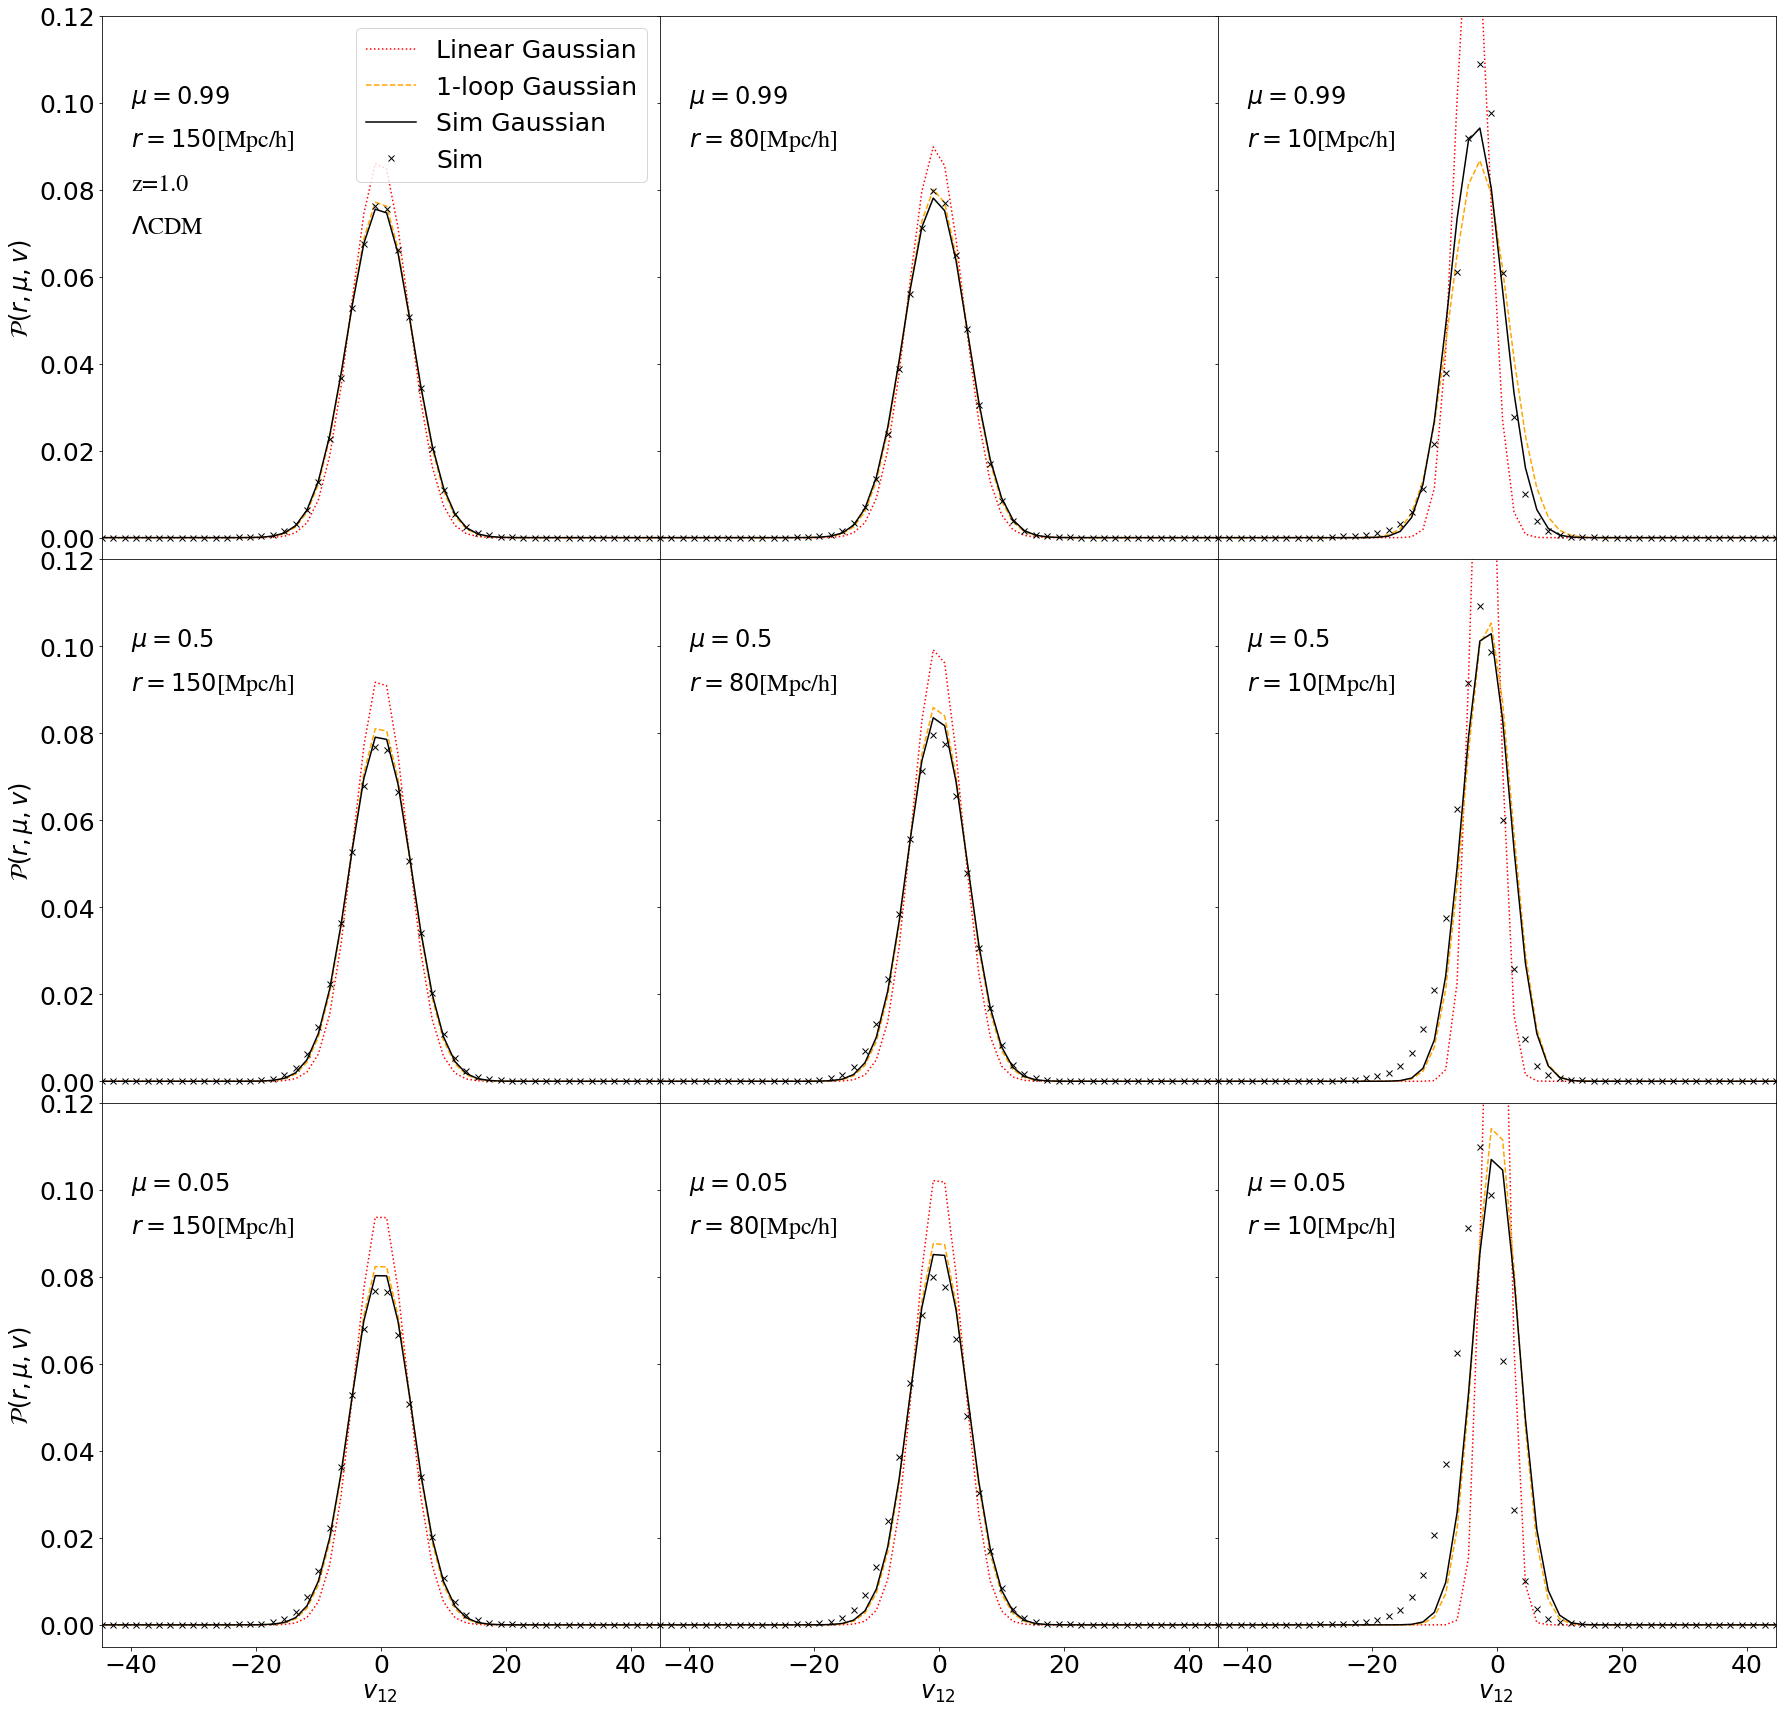

In [29]:
#Compare theory and measured PDF 
V = np.linspace(min(v12p_simu), max(v12p_simu))

myloff=sigma_iso/mybias
mysoff=0

plt.figure(figsize=(30,30))
ax = plt.subplot(3,3,1)
muval = 0.99
rval = 150
plt.plot(V, pdf_theory_lin(rval,muval,V) , linestyle='dotted', color='red' ,label='Linear Gaussian')
plt.plot(V, pdf_theory_loop(rval,muval,V, myloff) , linestyle='dashed', color='orange' ,label='1-loop Gaussian')
plt.plot(V, pdf_gsm_sim(rval,muval,V, mysoff) , linestyle='solid', color='k' ,label='Sim Gaussian')
plt.plot(V, mypdf(rval, muval, V) , linestyle='none',marker='x',color='k' ,label='Sim')
plt.text(-40, 0.08 , 'z='+zred,  **font3 )
plt.text(-40, 0.07 ,'$\Lambda$CDM',  **font3 )
plt.text(-40, 0.1 ,'$\mu=0.99$',  **font3 )
plt.text(-40, 0.09 ,'$r=150$[Mpc/h]',  **font3 )
plt.ylim(-0.005,0.12)
plt.xlim(min(v12p_simu),max(v12p_simu))
plt.legend(loc='best',prop={'size': 25})
plt.ylabel("$\mathcal{P}(r,\mu,v)$",**font4)

ax.tick_params(axis='both', which='major', labelsize=25)


ax = plt.subplot(3,3,2)
muval = 0.99
rval = 80
plt.plot(V, pdf_theory_lin(rval,muval,V) , linestyle='dotted', color='red' ,label='Linear GSM')
plt.plot(V, pdf_theory_loop(rval,muval,V, myloff) , linestyle='dashed', color='orange' ,label='1-loop GSM')
plt.plot(V, pdf_gsm_sim(rval,muval,V, mysoff) , linestyle='solid', color='k' ,label='Sim GSM')
plt.plot(V, mypdf(rval, muval, V) , linestyle='none',marker='x',color='k' ,label='Sim')
plt.text(-40, 0.1 ,'$\mu=0.99$',  **font3 )
plt.text(-40, 0.09 ,'$r=80$[Mpc/h]',  **font3 )
plt.ylim(-0.005,0.12)
plt.xlim(min(v12p_simu),max(v12p_simu))

ax.tick_params(axis='both', which='major', labelsize=25)



ax = plt.subplot(3,3,3)
muval = 0.99
rval = 10
plt.plot(V, pdf_theory_lin(rval,muval,V) , linestyle='dotted', color='red' ,label='Linear GSM')
plt.plot(V, pdf_theory_loop(rval,muval,V, myloff) , linestyle='dashed', color='orange' ,label='1-loop GSM')
plt.plot(V, pdf_gsm_sim(rval,muval,V, mysoff) , linestyle='solid', color='k' ,label='Sim GSM')
plt.plot(V, mypdf(rval, muval, V) , linestyle='none',marker='x',color='k' ,label='Sim')
plt.text(-40, 0.1 ,'$\mu=0.99$',  **font3 )
plt.text(-40, 0.09 ,'$r=10$[Mpc/h]',  **font3 )
plt.ylim(-0.005,0.12)
plt.xlim(min(v12p_simu),max(v12p_simu))
ax.tick_params(axis='both', which='major', labelsize=25)


ax = plt.subplot(3,3,4)
muval = 0.5
rval = 150
plt.plot(V, pdf_theory_lin(rval,muval,V) , linestyle='dotted', color='red' ,label='Linear GSM')
plt.plot(V, pdf_theory_loop(rval,muval,V, myloff) , linestyle='dashed', color='orange' ,label='1-loop GSM')
plt.plot(V, pdf_gsm_sim(rval,muval,V, mysoff) , linestyle='solid', color='k' ,label='Sim GSM')
plt.plot(V, mypdf(rval, muval, V) , linestyle='none',marker='x',color='k' ,label='Sim')
plt.text(-40, 0.1 ,'$\mu=0.5$',  **font3 )
plt.text(-40, 0.09 ,'$r=150$[Mpc/h]',  **font3 )
plt.ylim(-0.005,0.12)
plt.xlim(min(v12p_simu),max(v12p_simu))
plt.ylabel("$\mathcal{P}(r,\mu,v)$",**font4)


ax.tick_params(axis='both', which='major', labelsize=25)


ax = plt.subplot(3,3,5)
muval = 0.5
rval = 80
plt.plot(V, pdf_theory_lin(rval,muval,V) , linestyle='dotted', color='red' ,label='Linear GSM')
plt.plot(V, pdf_theory_loop(rval,muval,V, myloff) , linestyle='dashed', color='orange' ,label='1-loop GSM')
plt.plot(V, pdf_gsm_sim(rval,muval,V, mysoff) , linestyle='solid', color='k' ,label='Sim GSM')
plt.plot(V, mypdf(rval, muval, V) , linestyle='none',marker='x',color='k' ,label='Sim')
plt.text(-40, 0.1 ,'$\mu=0.5$',  **font3 )
plt.text(-40, 0.09 ,'$r=80$[Mpc/h]',  **font3 )
plt.ylim(-0.005,0.12)
plt.xlim(min(v12p_simu),max(v12p_simu))
ax.tick_params(axis='both', which='major', labelsize=25)


ax = plt.subplot(3,3,6)
muval = 0.5
rval = 10
plt.plot(V, pdf_theory_lin(rval,muval,V) , linestyle='dotted', color='red' ,label='Linear GSM')
plt.plot(V, pdf_theory_loop(rval,muval,V, myloff) , linestyle='dashed', color='orange' ,label='1-loop GSM')
plt.plot(V, pdf_gsm_sim(rval,muval,V, mysoff) , linestyle='solid', color='k' ,label='Sim GSM')
plt.plot(V, mypdf(rval, muval, V) , linestyle='none',marker='x',color='k' ,label='Sim')

plt.text(-40, 0.1 ,'$\mu=0.5$',  **font3 )
plt.text(-40, 0.09 ,'$r=10$[Mpc/h]',  **font3 )
plt.ylim(-0.005,0.12)
plt.xlim(min(v12p_simu),max(v12p_simu))
ax.tick_params(axis='both', which='major', labelsize=25)




ax = plt.subplot(3,3,7)
muval = 0.05
rval = 150
plt.plot(V, pdf_theory_lin(rval,muval,V) , linestyle='dotted', color='red' ,label='Linear GSM')
plt.plot(V, pdf_theory_loop(rval,muval,V, myloff) , linestyle='dashed', color='orange' ,label='1-loop GSM')
plt.plot(V, pdf_gsm_sim(rval,muval,V, mysoff) , linestyle='solid', color='k' ,label='Sim GSM')
plt.plot(V, mypdf(rval, muval, V) , linestyle='none',marker='x',color='k' ,label='Sim')
plt.text(-40, 0.1 ,'$\mu=0.05$',  **font3 )
plt.text(-40, 0.09 ,'$r=150$[Mpc/h]',  **font3 )
plt.ylim(-0.005,0.12)
plt.xlim(min(v12p_simu),max(v12p_simu))
plt.ylabel("$\mathcal{P}(r,\mu,v)$",**font4)
plt.xlabel("$v_{12}$ ", **font4)
ax.tick_params(axis='both', which='major', labelsize=25)


ax = plt.subplot(3,3,8)
muval = 0.05
rval = 80
plt.plot(V, pdf_theory_lin(rval,muval,V) , linestyle='dotted', color='red' ,label='Linear GSM')
plt.plot(V, pdf_theory_loop(rval,muval,V, myloff) , linestyle='dashed', color='orange' ,label='1-loop GSM')
plt.plot(V, pdf_gsm_sim(rval,muval,V, mysoff) , linestyle='solid', color='k' ,label='Sim GSM')
plt.plot(V, mypdf(rval, muval, V) , linestyle='none',marker='x',color='k' ,label='Sim')
plt.text(-40, 0.1 ,'$\mu=0.05$',  **font3 )
plt.text(-40, 0.09 ,'$r=80$[Mpc/h]',  **font3 )
plt.ylim(-0.005,0.12)
plt.xlim(min(v12p_simu),max(v12p_simu))
plt.xlabel("$v_{12}$ ", **font4)
ax.tick_params(axis='both', which='major', labelsize=25)


ax = plt.subplot(3,3,9)
muval = 0.05
rval = 10
plt.plot(V, pdf_theory_lin(rval,muval,V) , linestyle='dotted', color='red' ,label='Linear GSM')
plt.plot(V, pdf_theory_loop(rval,muval,V, myloff) , linestyle='dashed', color='orange' ,label='1-loop GSM')
plt.plot(V, pdf_gsm_sim(rval,muval,V, mysoff) , linestyle='solid', color='k' ,label='Sim GSM')
plt.plot(V, mypdf(rval, muval, V) , linestyle='none',marker='x',color='k' ,label='Sim')
plt.text(-40, 0.1 ,'$\mu=0.05$',  **font3 )
plt.text(-40, 0.09 ,'$r=10$[Mpc/h]',  **font3 )
plt.ylim(-0.005,0.12)
plt.xlim(min(v12p_simu),max(v12p_simu))
plt.xlabel("$v_{12}$ ", **font4)
ax.tick_params(axis='both', which='major', labelsize=25)


plt.setp(plt.subplot(3,3,1).get_xticklabels(), visible=False)
plt.setp(plt.subplot(3,3,2).get_xticklabels(), visible=False)
plt.setp(plt.subplot(3,3,3).get_xticklabels(), visible=False)
plt.setp(plt.subplot(3,3,4).get_xticklabels(), visible=False)
plt.setp(plt.subplot(3,3,5).get_xticklabels(), visible=False)
plt.setp(plt.subplot(3,3,6).get_xticklabels(), visible=False)

plt.setp(plt.subplot(3,3,2).get_yticklabels(), visible=False)
plt.setp(plt.subplot(3,3,3).get_yticklabels(), visible=False)
plt.setp(plt.subplot(3,3,5).get_yticklabels(), visible=False)
plt.setp(plt.subplot(3,3,6).get_yticklabels(), visible=False)
plt.setp(plt.subplot(3,3,8).get_yticklabels(), visible=False)
plt.setp(plt.subplot(3,3,9).get_yticklabels(), visible=False)


plt.subplots_adjust(hspace=0.0)
plt.subplots_adjust(wspace=0.0)


## GSM calculation - Equation 2.5 of 1911.04391

In [34]:
# Calculate the perpendicular and parallel separations in redshift space 
def rscale(s, mu):
    r_pi = s*mu
    r_sigma = s*np.sqrt(1-mu**2)
    return r_pi, r_sigma

In [77]:
# Print offset between linear and 1-loop v_12, sigma_iso, offset of s_{12,parallel} from sims and linear theory and linear bias 
print(myoffsetloop,sigma_iso,myoffset,mybias)

0.09313254653660508 14.487100000000002 6.575264476104152 2.77


In [79]:
# Minimum separation to integrate over - see 
rmin = 1

# 1-loop PT isotropic contribution to sigma_12 - used as a free parameter in 1911.04391
#sigmaiso = 7.5 # found to fit z=0.5 well  
sigmaiso = 4.2 # found to fit z=1 well  

# GSM integrand 
def integrandGSM(r_sigma, r_pi, y):
    r = np.sqrt(y**2 + r_sigma**2)
    mu =(y/r)
    
    if (r<rmin):
        return 0

    #GSM terms: PDF and real space correlation function
    
    # Linear v_12, s_12
#     pdist =pdf_theory_lin(r, mu, r_pi-y)
#     xiCF = mybias**2*corrFunc_intp_lin(r) # linear theory

    # 1-loop v_12, s_12
    pdist =pdf_theory_loop(r, mu, r_pi-y, sigmaiso)
    xiCF = mybias**2*corrFunc_intp_hf(r)
    
    # Simulation v_12, s_12
    #pdist = pdf_gsm_sim(r, mu, r_pi-y, 0)
    #xiCF = xi_sim_full(r)
    
    integrand = (1.+ xiCF)*pdist
    return integrand


In [80]:
# Integrate 
def integralGSM(s, mu_s, dy=0.5, yspan = 50):
    r_pi, r_sigma = rscale(s, mu_s)
    ymin = r_pi - yspan
    ymax = r_pi + yspan
    #print("yminmax",ymin,ymax)
    yvec = np.arange(ymin, ymax, dy)
    intvec = np.array([integrandGSM(r_sigma, r_pi, yi) for yi in yvec])
    integral = sci.simps(intvec, yvec)
    return integral

# define the 2D GSM spectrum
def xi_S(s, mu):
    return integralGSM(s,mu)-1

xi_S_v = np.vectorize(xi_S)

In [81]:
memory.clear()
xi_S = memory.cache(xi_S)

# create array of 2D spectrum in mu from -1,1

# Span of redshift space separation 
smin = 1
smax = 249 # should not be larger than 300 - yspan ---> see integralGSM
npoints = 229

svec = np.logspace(np.log10(smin),np.log10(smax),npoints) #logspace better than linspace!
muvec = np.linspace(-1.0,1.0,50)
def multIntegrand_of_s(s):
    mult_s = xi_S_v(s, muvec)
    return mult_s

In [82]:
# Test some values
print(xi_S(smax, -1), xi_S(smax,0), xi_S(smin, 1),xi_S(smin, 0))

-0.0007273044562048359 2.2189730262134333e-06 8.915787774228068 16.115156170128735


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


## Get the streaming model correlation function multipoles

`npoints` is important - the more npoints the better the final performance, but gets slower. Also, `logspace` binning works better than `linspace`.

In [83]:
#this part crashes sometimes and needs to be re run
start=timer()
intvec_tuple = Parallel(n_jobs=3)(delayed(multIntegrand_of_s)(s) for s in svec)
end = timer()
print ("Execution time HH:MM:SS:",timedelta(seconds=end-start))

Execution time HH:MM:SS: 0:02:13.176743


In [84]:
intvecM_arr = np.array(intvec_tuple)

In [85]:
# Define the xi(s) multipoles 
def xi_S_ell(ell=0):
    polL=special.legendre(ell)
    ellfact = (2*ell+1)/2
    mufact=polL(muvec)
    #print(mufact)
    Pl_mufact = np.array([mufact * intmu for intmu in intvecM_arr])
    res = np.array([ellfact*sci.simps(intL2, muvec) for intL2 in Pl_mufact])
    return res

# Create splines for xi_0 and xi_2 
xi_S_0 = xi_S_ell(ell=0)
xi_S_2 = xi_S_ell(ell=2)

xi_S_0_intp = interp1d(svec,xi_S_0, kind='cubic')
xi_S_2_intp = interp1d(svec,xi_S_2, kind='cubic')

In [86]:
#Compute Kaiser xi02 
kvecl, pkvecl = pkReal_logSampling(z_key=zred, model='linear')

P0 = pkvecl * ( mybias**2 + 2/3 * mybias * frate + 1/5 * frate**2)
P2 = pkvecl * (  mybias * frate * 4/3 + 4/7 * frate**2)
P4 = pkvecl * (  8/35 * frate**2)

xi0l = P2xi(kvecl,l=0,lowring=True)
xi2l = P2xi(kvecl,l=2,lowring=True)
xi4l = P2xi(kvecl,l=4,lowring=True)


ssl, CFL0 = xi0l(P0, extrap=True)
ssl2, CFL2 = xi2l(P2, extrap=True)
ssl2, CFL4 = xi4l(P4, extrap=True)

CFL_intp0 = interp1d(ssl,CFL0, kind='cubic',fill_value='extrapolate')
CFL_intp2 = interp1d(ssl2,CFL2, kind='cubic',fill_value='extrapolate')
CFL_intp4 = interp1d(ssl2,CFL4, kind='cubic',fill_value='extrapolate')


# corrFunc calculated once and for all
ssvec = np.linspace(1,300,300) 
corrFunc_intp_tab0 = np.array([CFL_intp0(r) for r in rvec])
corrFunc_intp_tab2 = np.array([CFL_intp2(r) for r in rvec])
corrFunc_intp_tab4 = np.array([CFL_intp4(r) for r in rvec])


corrFunc_intp0 = interp1d(rvec,corrFunc_intp_tab0, kind='cubic')
corrFunc_intp2 = interp1d(rvec,corrFunc_intp_tab2, kind='cubic')
corrFunc_intp4 = interp1d(rvec,corrFunc_intp_tab4, kind='cubic')

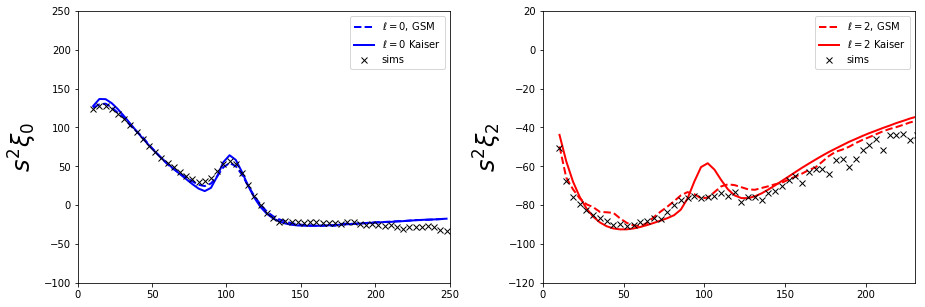

In [87]:
# Compare the correlation function multipoles: Kaiser, GSM and N-body 
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(s_simu,  s_simu**2*xi_S_0_intp(s_simu) , color='blue', linestyle='dashed', label=r'$\ell = 0$, GSM', lw=2.0)
plt.plot(s_simu, s_simu**2*corrFunc_intp0(s_simu) , color='blue',  label=r'$\ell = 0$ Kaiser', lw=2.0)
plt.plot(s_simu,  s_simu**2*xi0_simu, linestyle='none', color='k',  marker='x',label='sims')
plt.ylim(-100,250)
plt.xlim(0,250)
plt.legend(loc='best')
plt.ylabel("$s^2 \\xi_0$",**font3)



plt.subplot(1,2,2)
plt.plot(s_simu,  s_simu**2*xi_S_2_intp(s_simu) , color='red', linestyle='dashed', label=r'$\ell = 2$, GSM', lw=2.0)
plt.plot(s_simu, s_simu**2*corrFunc_intp2(s_simu) , color='red',  label=r'$\ell = 2$ Kaiser', lw=2.0)
plt.plot(s_simu,  s_simu**2*xi2_simu, linestyle='none', color='k', marker='x',label='sims')
plt.ylim(-120,20)
plt.xlim(0,230)
plt.legend(loc='best')
plt.ylabel("$s^2 \\xi_2 $",**font3)


plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=0.25)


### Fourier transform multipoles to get power spectrum multipoles 

In [94]:
smin =1
smax = 230
#number of sampled points
s_npoints = 56 # some sensitivity to this parameter! 

svec_log = np.logspace(np.log10(smin), np.log10(smax), s_npoints)
xi_S_0_lg = np.array([xi_S_0_intp(sl) for sl in svec_log])
xi_S_2_lg = np.array([xi_S_2_intp(sl) for sl in svec_log])

P0 = xi2P(svec_log, l=0, lowring=True)
k_s, P0_s = P0(xi_S_0_lg, extrap=True)

P2 = xi2P(svec_log, l=2, lowring=True)
k_s_2, P2_s = P2(xi_S_2_lg, extrap=True) 


# save p0, p2 
np.savetxt(outputfolder+'/p02_gsm_th_iso4.1_z1.txt', np.column_stack([k_s, P0_s, k_s_2 ,P2_s]))
# save xi0, xi2 
np.savetxt(outputfolder+'/xi02_gsm_th_iso4.1_z1.txt', np.column_stack([svec, xi_S_0, xi_S_2]))


# Create splines of HyPk multipoles
P0th = interp1d(k_s, P0_s, kind='cubic',fill_value='extrapolate')
P2th = interp1d(k_s_2, P2_s, kind='cubic',fill_value='extrapolate')

In [95]:
# Go back to correlation function to check consistency!
xi0nl = P2xi(k_s,l=0,lowring=True)
xi2nl = P2xi(k_s_2,l=2,lowring=True)

ssl, CFL0nl = xi0nl(P0_s, extrap=True)
ssl2, CFL2nl = xi2nl(P2_s, extrap=True)

CFL_intp0 = interp1d(ssl,CFL0nl, kind='cubic',fill_value='extrapolate')
CFL_intp2 = interp1d(ssl2,CFL2nl, kind='cubic',fill_value='extrapolate')


(0.7, 1.3)

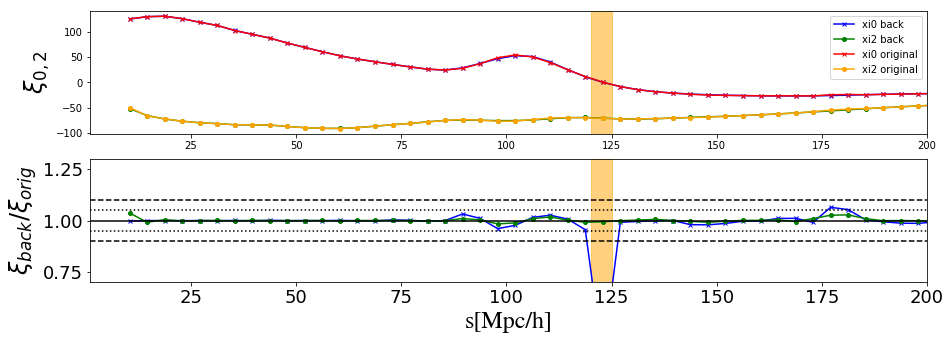

In [96]:
# Check consistency of Fourier transforms!! 
plt.figure(figsize=(15,5))

ax = plt.subplot(2,1,1)
plt.plot(s_simu, s_simu**2*CFL_intp0(s_simu)  , color='blue', marker='x', markersize=4, label = 'xi0 back')
plt.plot(s_simu, s_simu**2*CFL_intp2(s_simu) , color='green', marker='o', markersize=4, label = 'xi2 back')
plt.plot(s_simu, s_simu**2*xi_S_0_intp(s_simu)  , color='red', marker='x', markersize=4, label = 'xi0 original')
plt.plot(s_simu, s_simu**2*xi_S_2_intp(s_simu) , color='orange', marker='o', markersize=4, label = 'xi2 original')

plt.ylabel("$\\xi_{0,2}$", **font4)
ax.axvspan(120, 125, alpha=0.5, color='orange')

plt.xlim(1,200)
#plt.ylim(0.85,1.3)
plt.legend()

ax = plt.subplot(2,1,2)
plt.plot(s_simu,CFL_intp0(s_simu)/xi_S_0_intp(s_simu)  , color='blue', marker='x', markersize=4, label = 'p0')
plt.plot(s_simu,CFL_intp2(s_simu)/xi_S_2_intp(s_simu) , color='green', marker='o', markersize=4, label = 'p2')

ax.axvspan(120, 125, alpha=0.5, color='orange')
ax.tick_params(axis='both', which='major', labelsize=18)
plt.ylabel("$\\xi_{back}/\\xi_{orig}$", **font4)
plt.xlabel("s[Mpc/h]", **font4)
plt.axhline(y=1., xmin=0., xmax=10,color='k')
plt.axhline(y=1.1, xmin=0., xmax=10,color='k',linestyle='dashed')
plt.axhline(y=1.05, xmin=0., xmax=10,color='k',linestyle='dotted')
plt.axhline(y=0.95, xmin=0., xmax=10,color='k',linestyle='dotted')
plt.axhline(y=0.9, xmin=0., xmax=10,color='k',linestyle='dashed')
plt.xlim(1,200)
plt.ylim(0.7,1.3)


## Plot $P_{\ell}$

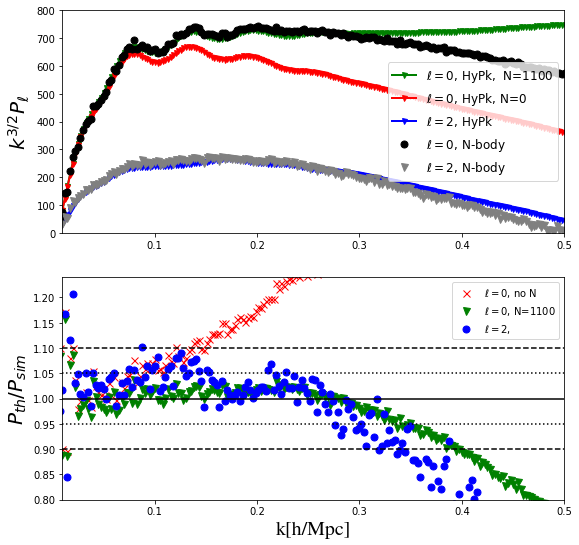

In [112]:
# Add halo shot noise parameter
myshot = 1100

plt.figure(figsize=(9,9))

ax = plt.subplot(2,1,1)
plt.plot(k_simu, (k_simu)**(3.0/2)*(P0th(k_simu)+myshot), color='green', marker='v', markersize=5, label=r'$\ell = 0$, HyPk,  N=1100', lw=2.0)
plt.plot(k_simu, (k_simu)**(3.0/2)*(P0th(k_simu)+0), color='red', marker='v', markersize=5, label=r'$\ell = 0$, HyPk, N=0', lw=2.0)
plt.plot(k_simu, (k_simu)**(3.0/2)*P2th(k_simu) , color='blue', marker='v', markersize=5, label=r'$\ell = 2$, HyPk', lw=2.0)


plt.plot(k_simu, (k_simu)**(3.0/2)*P0_simu , color='black', marker='o', linestyle='none', markersize=7, label=r'$\ell = 0$, N-body', lw=2.0)
plt.plot(k_simu, (k_simu)**(3.0/2)*P2_simu ,  color='grey', marker='v',linestyle='none', markersize=7, label=r'$\ell = 2$, N-body', lw=2.0)
plt.xlim(0.01,0.5)
plt.ylim(0,800)
plt.legend(loc='best',prop={'size': 12})
plt.ylabel("$k^{3/2} P_{\ell} $", **font2)

ax = plt.subplot(2,1,2)
plt.plot(k_simu, P0_simu/(P0th(k_simu)) , color='red', marker='x', linestyle='none', markersize=7, label=r'$\ell = 0$, no N', lw=2.0)
plt.plot(k_simu, P0_simu/(P0th(k_simu)+myshot) , color='green', marker='v', linestyle='none', markersize=7, label=r'$\ell = 0$, N=1100', lw=2.0)
plt.plot(k_simu, P2_simu/P2th(k_simu) , color='blue', marker='o', linestyle='none', markersize=7, label=r'$\ell = 2$,', lw=2.0)



plt.legend(loc='best',prop={'size': 12})
plt.ylabel("$P_{th}/P_{sim}$", **font2)
plt.xlabel("k[h/Mpc]", **font2)

plt.axhline(y=1., xmin=0., xmax=10,color='k')
plt.axhline(y=1.1, xmin=0., xmax=10,color='k',linestyle='dashed')
plt.axhline(y=1.05, xmin=0., xmax=10,color='k',linestyle='dotted')
plt.axhline(y=0.95, xmin=0., xmax=10,color='k',linestyle='dotted')
plt.axhline(y=0.9, xmin=0., xmax=10,color='k',linestyle='dashed')
plt.xlim(0.01,0.5)
plt.ylim(0.8,1.24)
plt.legend()



#### End notebook